## Tecnológico de Costa Rica

### Autor: Jorge Andrés Brenes Alfaro

## Virtual_PAHM

El código desarrollado a continuación está basado en [1]. La red diseñada es la encargada de reproducir el comportamiento de entrada y salida de una planta prototipo de péndulo amortiguado a hélice (PAHM).

## Bibliotecas

In [1]:
#!pip install wandb

In [2]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

import wandb
from wandb.keras import WandbCallback

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.backend import clear_session

import warnings
warnings.filterwarnings('ignore')

In [3]:
wandb.login()
run = wandb.init(project = 'Virtual_PAHM',
                config = {
                    'epochs':1000,
                    'batch_size': 64,
                    'loss_function':'Adam',
                    'Architecture': 'RNN',
                    'dataset':'Proprio'
                })

wandb: Currently logged in as: jorgebre98. Use `wandb login --relogin` to force relogin


## 1. Definición del modelo
Se define el espacio de estados de la planta PAHM de la siguiente forma:
$$\dot{x}(t)=A*x(t)+Bu(t)\\
y(t)=C*x(t)$$
Donde:
- A, B y C son matrices.
- x(t) es el estado en el tiempo t.
- u(t) es la entrada externa.
- y(t) es la salida.

### 1.1 Función para simular la dinámica de la planta

In [4]:
def dinamica_modelo(A,B,C,cond_inicial,input_sequence, time_steps,muestreo):
    I = np.identity(A.shape[0])
    Ad = inv(I - muestreo*A)
    Bd = Ad*muestreo*B
    Xd = np.zeros(shape=(A.shape[0],time_steps + 1)) # # Vectores de 2 x 201 / X en tiempo discreto
    Yd = np.zeros(shape=(C.shape[0],time_steps + 1)) # # Vectores de 2 x 201 / Salida en tiempo discreto
    
    for i in range(0,time_steps):
        if i==0:
            Xd[:,[i]] = cond_inicial
            Yd[:,[i]] = C*cond_inicial
            x = Ad*cond_inicial + Bd*input_sequence[i]
        else:
            Xd[:,[i]] = x
            Yd[:,[i]] = C*x
            x = Ad*x + Bd*input_sequence[i]
            
    Xd[:,[-1]] = x
    Yd[:,[-1]] = C*x
    return Xd, Yd

### 1.2 Definición del modelo en tiempo continuo

In [5]:
A = np.matrix([[0, 1],[-0.9413, -0.149]])
B = np.matrix([[0],[0.149]])
C = np.matrix([[1, 0]])

# Definición del tiempo de muestreo
tiempo = 200
sampling = 0.2
input_seq_train = np.random.rand(tiempo,1) # Secuencia de entrada para la simulación
                                           # Es aleatoria para que sea rica en información
x0_train = np.random.rand(2,1) # Condición inicial
input_seq=np.ones(tiempo) # Escalón

### 1.3 Conversión a tiempo discreto y dinámica de la planta

Text(0.5, 1.0, 'Respuesta al escalón')

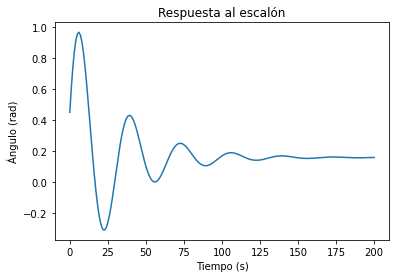

In [6]:
# Dinámica de la planta
state,output_train=dinamica_modelo(A,B,C,x0_train,input_seq,tiempo,sampling)  

plt.plot(output_train[0])
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.title('Respuesta al escalón')

## 2. Creación de datos

Se replica el mismo método para crear datos de entrenamiento, validación y prueba. La diferencia radica en que se hace diferentes secuencias de entrada y condiciones iniciales de planta

### 2.1 Datos de entrenamiento

In [7]:
train_label = np.reshape(output_train.T,(1,output_train.T.shape[0],1)) # Salida para el entrenamiento

input_seq_train = np.reshape(input_seq_train,(input_seq_train.shape[0],1)) # El tamaño no cambia, ¿por qué cambian los valores?
tmp_train = np.concatenate((input_seq_train, np.zeros(shape=(input_seq_train.shape[0],1))), axis=1)
tmp_train = np.concatenate((x0_train.T,tmp_train), axis=0)
train_data = np.reshape(tmp_train, (1,tmp_train.shape[0],tmp_train.shape[1])) # Entrada para el entrenamiento

### 2.2 Datos de validación

In [8]:
input_seq_val = np.random.rand(tiempo,1)
x0_val = np.random.rand(2,1)

state_val,output_val = dinamica_modelo(A,B,C,x0_val,input_seq_val,tiempo,sampling)
val_label = np.reshape(output_val.T,(1,output_val.T.shape[0],1)) # Salida de datos de validación

input_seq_val = np.reshape(input_seq_val,(input_seq_val.shape[0],1))
tmp_val = np.concatenate((input_seq_val, np.zeros(shape=(input_seq_val.shape[0],1))), axis=1)
tmp_val = np.concatenate((x0_val.T,tmp_val), axis=0)
val_data = np.reshape(tmp_val, (1,tmp_val.shape[0],tmp_val.shape[1])) # Entrada para datos de validación

### 2.3 Datos de prueba

In [9]:
input_seq_test = np.random.rand(tiempo,1)
x0_test = np.random.rand(2,1)

state_test,output_test = dinamica_modelo(A,B,C,x0_test,input_seq_test,tiempo,sampling)
test_label = np.reshape(output_test.T,(1,output_test.T.shape[0],1)) # Salida de datos de prueba

input_seq_test = np.reshape(input_seq_test,(input_seq_test.shape[0],1))
tmp_test = np.concatenate((input_seq_test, np.zeros(shape=(input_seq_test.shape[0],1))), axis=1)
tmp_test = np.concatenate((x0_test.T,tmp_test), axis=0)
test_data = np.reshape(tmp_test, (1,tmp_test.shape[0],tmp_test.shape[1])) # Entrada para datos de validación

## 3. Creación de la red neuronal

### 3.1 Definición del modelo

In [10]:
clear_session()

model = Sequential()
#model.add(SimpleRNN(32, input_shape=(train_data.shape[1],train_data.shape[2]),return_sequences=True))
model.add(GRU(32, input_shape=(train_data.shape[1],train_data.shape[2]),return_sequences=True))
#model.add(LSTM(32, input_shape=(train_data.shape[1],train_data.shape[2]),return_sequences=True))
model.add(Dense(1))
#model.add(TimeDistributed(Dense(1)))  #there is no difference between this and model.add(Dense(1))...
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 201, 32)           3456      
_________________________________________________________________
dense (Dense)                (None, 201, 1)            33        
Total params: 3,489
Trainable params: 3,489
Non-trainable params: 0
_________________________________________________________________


### 3.2 Entrenamiento de la red

In [13]:
history = model.fit(train_data, train_label , 
                  epochs=1000, batch_size=1, 
                  validation_data=(val_data,val_label), verbose=2)#, callbacks=[WandbCallback()])

#model.save(filepath, save_format="h5")

# use the test data to predict the model response
testPredict = model.predict(test_data)
#run.join()

Epoch 1/1000
1/1 - 0s - loss: 1.3661e-06 - mse: 1.3661e-06 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 2/1000
1/1 - 0s - loss: 1.3638e-06 - mse: 1.3638e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 3/1000
1/1 - 0s - loss: 1.3586e-06 - mse: 1.3586e-06 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 4/1000
1/1 - 0s - loss: 1.3541e-06 - mse: 1.3541e-06 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 5/1000
1/1 - 0s - loss: 1.3527e-06 - mse: 1.3527e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 6/1000
1/1 - 0s - loss: 1.3532e-06 - mse: 1.3532e-06 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 7/1000
1/1 - 0s - loss: 1.3531e-06 - mse: 1.3531e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/1000
1/1 - 0s - loss: 1.3508e-06 - mse: 1.3508e-06 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 9/1000
1/1 - 0s - loss: 1.3471e-06 - mse: 1.3471e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 10/1000
1/1 - 0s - loss: 1.3441e-06 - mse: 1.3441e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 11/1000
1/1 - 0s - loss: 1.3427e-

Epoch 86/1000
1/1 - 0s - loss: 1.2303e-06 - mse: 1.2303e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 87/1000
1/1 - 0s - loss: 1.2289e-06 - mse: 1.2289e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 88/1000
1/1 - 0s - loss: 1.2275e-06 - mse: 1.2275e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 89/1000
1/1 - 0s - loss: 1.2261e-06 - mse: 1.2261e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 90/1000
1/1 - 0s - loss: 1.2248e-06 - mse: 1.2248e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 91/1000
1/1 - 0s - loss: 1.2234e-06 - mse: 1.2234e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 92/1000
1/1 - 0s - loss: 1.2220e-06 - mse: 1.2220e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 93/1000
1/1 - 0s - loss: 1.2207e-06 - mse: 1.2207e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 94/1000
1/1 - 0s - loss: 1.2193e-06 - mse: 1.2193e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 95/1000
1/1 - 0s - loss: 1.2179e-06 - mse: 1.2179e-06 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 96/1000
1/1 - 0s - loss:

Epoch 170/1000
1/1 - 0s - loss: 3.3554e-06 - mse: 3.3554e-06 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 171/1000
1/1 - 0s - loss: 4.8763e-06 - mse: 4.8763e-06 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 172/1000
1/1 - 0s - loss: 7.3244e-06 - mse: 7.3244e-06 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 173/1000
1/1 - 0s - loss: 1.1275e-05 - mse: 1.1275e-05 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 174/1000
1/1 - 0s - loss: 1.6883e-05 - mse: 1.6883e-05 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 175/1000
1/1 - 0s - loss: 2.4407e-05 - mse: 2.4407e-05 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 176/1000
1/1 - 0s - loss: 3.1204e-05 - mse: 3.1204e-05 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 177/1000
1/1 - 0s - loss: 3.4652e-05 - mse: 3.4652e-05 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 178/1000
1/1 - 0s - loss: 2.8959e-05 - mse: 2.8959e-05 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 179/1000
1/1 - 0s - loss: 1.6715e-05 - mse: 1.6715e-05 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 180/1000
1/1 -

Epoch 254/1000
1/1 - 0s - loss: 1.0431e-06 - mse: 1.0431e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 255/1000
1/1 - 0s - loss: 1.0453e-06 - mse: 1.0453e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 256/1000
1/1 - 0s - loss: 1.0480e-06 - mse: 1.0480e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 257/1000
1/1 - 0s - loss: 1.0475e-06 - mse: 1.0475e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 258/1000
1/1 - 0s - loss: 1.0438e-06 - mse: 1.0438e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 259/1000
1/1 - 0s - loss: 1.0394e-06 - mse: 1.0394e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 260/1000
1/1 - 0s - loss: 1.0370e-06 - mse: 1.0370e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 261/1000
1/1 - 0s - loss: 1.0371e-06 - mse: 1.0371e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 262/1000
1/1 - 0s - loss: 1.0382e-06 - mse: 1.0382e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 263/1000
1/1 - 0s - loss: 1.0382e-06 - mse: 1.0382e-06 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 264/1000
1/1 -

Epoch 338/1000
1/1 - 0s - loss: 9.6728e-07 - mse: 9.6728e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 339/1000
1/1 - 0s - loss: 9.6643e-07 - mse: 9.6643e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 340/1000
1/1 - 0s - loss: 9.6560e-07 - mse: 9.6560e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 341/1000
1/1 - 0s - loss: 9.6475e-07 - mse: 9.6475e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 342/1000
1/1 - 0s - loss: 9.6395e-07 - mse: 9.6395e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 343/1000
1/1 - 0s - loss: 9.6313e-07 - mse: 9.6313e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 344/1000
1/1 - 0s - loss: 9.6230e-07 - mse: 9.6230e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 345/1000
1/1 - 0s - loss: 9.6146e-07 - mse: 9.6146e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 346/1000
1/1 - 0s - loss: 9.6065e-07 - mse: 9.6065e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 347/1000
1/1 - 0s - loss: 9.5983e-07 - mse: 9.5983e-07 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 348/1000
1/1 -

Epoch 422/1000
1/1 - 0s - loss: 9.1330e-06 - mse: 9.1330e-06 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 423/1000
1/1 - 0s - loss: 1.6082e-05 - mse: 1.6082e-05 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 424/1000
1/1 - 0s - loss: 1.5888e-05 - mse: 1.5888e-05 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 425/1000
1/1 - 0s - loss: 8.5760e-06 - mse: 8.5760e-06 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 426/1000
1/1 - 0s - loss: 1.9201e-06 - mse: 1.9201e-06 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 427/1000
1/1 - 0s - loss: 1.6700e-06 - mse: 1.6700e-06 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 428/1000
1/1 - 0s - loss: 6.2439e-06 - mse: 6.2439e-06 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 429/1000
1/1 - 0s - loss: 9.5117e-06 - mse: 9.5117e-06 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 430/1000
1/1 - 0s - loss: 7.6073e-06 - mse: 7.6073e-06 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 431/1000
1/1 - 0s - loss: 3.1192e-06 - mse: 3.1192e-06 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 432/1000
1/1 -

Epoch 506/1000
1/1 - 0s - loss: 8.5391e-07 - mse: 8.5391e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 507/1000
1/1 - 0s - loss: 8.5366e-07 - mse: 8.5366e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 508/1000
1/1 - 0s - loss: 8.5417e-07 - mse: 8.5417e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 509/1000
1/1 - 0s - loss: 8.5432e-07 - mse: 8.5432e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 510/1000
1/1 - 0s - loss: 8.5353e-07 - mse: 8.5353e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 511/1000
1/1 - 0s - loss: 8.5199e-07 - mse: 8.5199e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 512/1000
1/1 - 0s - loss: 8.5048e-07 - mse: 8.5048e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 513/1000
1/1 - 0s - loss: 8.4956e-07 - mse: 8.4956e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 514/1000
1/1 - 0s - loss: 8.4928e-07 - mse: 8.4928e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 515/1000
1/1 - 0s - loss: 8.4923e-07 - mse: 8.4923e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 516/1000
1/1 -

Epoch 590/1000
1/1 - 0s - loss: 8.0516e-07 - mse: 8.0516e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 591/1000
1/1 - 0s - loss: 8.0462e-07 - mse: 8.0462e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 592/1000
1/1 - 0s - loss: 8.0407e-07 - mse: 8.0407e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 593/1000
1/1 - 0s - loss: 8.0353e-07 - mse: 8.0353e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 594/1000
1/1 - 0s - loss: 8.0300e-07 - mse: 8.0300e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 595/1000
1/1 - 0s - loss: 8.0246e-07 - mse: 8.0246e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 596/1000
1/1 - 0s - loss: 8.0191e-07 - mse: 8.0191e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 597/1000
1/1 - 0s - loss: 8.0137e-07 - mse: 8.0137e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 598/1000
1/1 - 0s - loss: 8.0084e-07 - mse: 8.0084e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 599/1000
1/1 - 0s - loss: 8.0030e-07 - mse: 8.0030e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 600/1000
1/1 -

Epoch 674/1000
1/1 - 0s - loss: 1.7666e-05 - mse: 1.7666e-05 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 675/1000
1/1 - 0s - loss: 6.1430e-06 - mse: 6.1430e-06 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 676/1000
1/1 - 0s - loss: 7.7481e-07 - mse: 7.7481e-07 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 677/1000
1/1 - 0s - loss: 5.3365e-06 - mse: 5.3365e-06 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 678/1000
1/1 - 0s - loss: 1.1773e-05 - mse: 1.1773e-05 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 679/1000
1/1 - 0s - loss: 1.1537e-05 - mse: 1.1537e-05 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 680/1000
1/1 - 0s - loss: 5.1127e-06 - mse: 5.1127e-06 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 681/1000
1/1 - 0s - loss: 8.4731e-07 - mse: 8.4731e-07 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 682/1000
1/1 - 0s - loss: 2.8887e-06 - mse: 2.8887e-06 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 683/1000
1/1 - 0s - loss: 6.9335e-06 - mse: 6.9335e-06 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 684/1000
1/1 -

Epoch 758/1000
1/1 - 0s - loss: 7.3375e-07 - mse: 7.3375e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 759/1000
1/1 - 0s - loss: 7.3174e-07 - mse: 7.3174e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 760/1000
1/1 - 0s - loss: 7.3116e-07 - mse: 7.3116e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 761/1000
1/1 - 0s - loss: 7.3174e-07 - mse: 7.3174e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 762/1000
1/1 - 0s - loss: 7.3219e-07 - mse: 7.3219e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 763/1000
1/1 - 0s - loss: 7.3163e-07 - mse: 7.3163e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 764/1000
1/1 - 0s - loss: 7.3025e-07 - mse: 7.3025e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 765/1000
1/1 - 0s - loss: 7.2901e-07 - mse: 7.2901e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 766/1000
1/1 - 0s - loss: 7.2857e-07 - mse: 7.2857e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 767/1000
1/1 - 0s - loss: 7.2868e-07 - mse: 7.2868e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 768/1000
1/1 -

Epoch 842/1000
1/1 - 0s - loss: 6.9799e-07 - mse: 6.9799e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 843/1000
1/1 - 0s - loss: 6.9762e-07 - mse: 6.9762e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 844/1000
1/1 - 0s - loss: 6.9722e-07 - mse: 6.9722e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 845/1000
1/1 - 0s - loss: 6.9685e-07 - mse: 6.9685e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 846/1000
1/1 - 0s - loss: 6.9648e-07 - mse: 6.9648e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 847/1000
1/1 - 0s - loss: 6.9609e-07 - mse: 6.9609e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 848/1000
1/1 - 0s - loss: 6.9571e-07 - mse: 6.9571e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 849/1000
1/1 - 0s - loss: 6.9533e-07 - mse: 6.9533e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 850/1000
1/1 - 0s - loss: 6.9495e-07 - mse: 6.9495e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 851/1000
1/1 - 0s - loss: 6.9458e-07 - mse: 6.9458e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 852/1000
1/1 -

Epoch 926/1000
1/1 - 0s - loss: 6.6942e-07 - mse: 6.6942e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 927/1000
1/1 - 0s - loss: 6.7011e-07 - mse: 6.7011e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 928/1000
1/1 - 0s - loss: 6.7138e-07 - mse: 6.7138e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 929/1000
1/1 - 0s - loss: 6.7362e-07 - mse: 6.7362e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 930/1000
1/1 - 0s - loss: 6.7744e-07 - mse: 6.7744e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 931/1000
1/1 - 0s - loss: 6.8384e-07 - mse: 6.8384e-07 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 932/1000
1/1 - 0s - loss: 6.9446e-07 - mse: 6.9446e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 933/1000
1/1 - 0s - loss: 7.1214e-07 - mse: 7.1214e-07 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 934/1000
1/1 - 0s - loss: 7.4154e-07 - mse: 7.4154e-07 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 935/1000
1/1 - 0s - loss: 7.9079e-07 - mse: 7.9079e-07 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 936/1000
1/1 -

In [ ]:
loss_accuracy = model.evaluate(test_data,test_label)
print(loss_accuracy)
#print('Test error rate: ', round((1-loss_accuracy)*100,2))

## 4. Plot the predicted and "true" output and plot training and validation losses

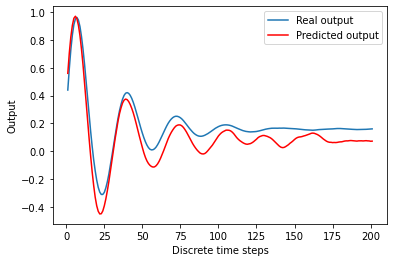

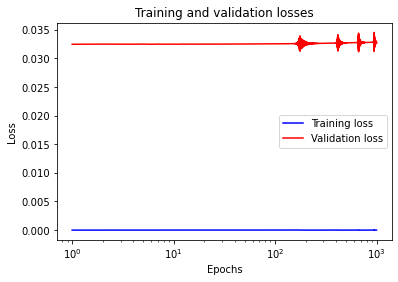

In [14]:
time_plot=range(1,tiempo+2)
plt.figure()
plt.plot(time_plot,testPredict[0,:,0], label='Real output')
plt.plot(time_plot,output_test[0,:],'r', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.show()

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.legend()
plt.show()

## 5. Bibliografía
-H. Kapasi, 2022. "Modeling Non-Linear Dynamic Systems with Neural Networks", 2022. [En línea]. Disponible en: https://towardsdatascience.com/modeling-non-linear-dynamic-systems-with-neural-networks-f3761bc92649. [Accesado el 7 de marzo del 2022].